# Time Evolution for HAP-fr channel

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from astropy.time import Time

In [2]:
#from gammapy.detect import compute_lima_on_off_image,compute_lima_image # quelle différence entre les deux ?

from gammapy.data import DataStore
from gammapy.irf import PSFKernel
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.datasets import MapDataset, Datasets, FluxPointsDataset
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    FoVBackgroundMaker,
)
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Models,
    SkyModel,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    TemplateSpatialModel,
    GaussianSpatialModel,
    FoVBackgroundModel
)
#from gammapy.stats import significance, excess # utiles ?
from gammapy.estimators import (
    #LiMaMapEstimator,
    TSMapEstimator,
    ExcessMapEstimator,
    FluxPointsEstimator
)


import gammapy
gammapy.__version__

'0.18.2'

In [3]:
src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

In [4]:
from pathlib import Path

# Directory for outputs

path = Path("../../../hess_results/GC_variability_0.18.2/hap-fr")
path.mkdir(exist_ok=True)

pathma = Path(path/"mapdatasets")
pathma.mkdir(exist_ok=True)

pathmo = Path(path/"models")
pathmo.mkdir(exist_ok=True)

# for consistency we will use the template using exp cutoff for both the central source and the DE
# but it will generally require that the cutoff of the DE be frozen and set to infinity (lambda = 0)

model_name = pathmo/"models_template_2cutoff.yaml" 

pathres = Path(path/"time_analysis_annee_par_annee_bis")
pathres.mkdir(exist_ok=True)

In [5]:
emin, emax = [0.5, 100] * u.TeV

e_bins = 20

energy_axis = MapAxis.from_energy_bounds(
    emin.value, emax.value, e_bins, unit="TeV"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    frame="galactic",
    proj="CAR",
    axes=[energy_axis],
)

geom2d = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    frame="galactic",
    proj="CAR",
)

emintrue, emaxtrue = [0.3,200] * u.TeV
e_bins_true = 30

energy_axis_true = MapAxis.from_energy_bounds(
    emintrue.value, emaxtrue.value, e_bins_true, unit="TeV", name="energy_true"
)

## Creating the datasets

In [6]:
datasets_year = Datasets.read(pathma/"datasets_year.yaml")

## Reading the model template

In [7]:
modelGC,modelG09, modeldiff= Models.read(model_name)

In [8]:
# if needed
modelGC.parameters["amplitude"].frozen = False
modelGC.parameters["amplitude"].value = 3.0e-12

modelGC.parameters["index"].frozen = True
modelGC.parameters["index"].value = 1.83

modelGC.spectral_model.parameters['lambda_'].frozen = True
modelGC.spectral_model.parameters['lambda_'].value = 0.158

modeldiff.parameters["amplitude"].frozen = False
modeldiff.parameters["amplitude"].value = 3.0e-12

modeldiff.parameters["index"].frozen = True
modeldiff.parameters["index"].value = 2.24

modeldiff.spectral_model.parameters['lambda_'].frozen = True
modeldiff.spectral_model.parameters['lambda_'].value = 0.0

## Constructing the mask

In [9]:
fit_region = RectangleSkyRegion(src_pos, 4*u.deg, 2*u.deg)

J1745_303_region = CircleSkyRegion(SkyCoord(358.6,  -0.6, unit="deg", frame="galactic"), 0.5 * u.deg)

fit_mask = geom.region_mask([fit_region])*geom.region_mask([J1745_303_region] , inside=False)

fit_mask = Map.from_geom(geom, data=fit_mask)

## Applying the mask and the model template

In [10]:
for year in range(2004,2020):
    datasets_year[f'map_{year}'].fit_mask = fit_mask
    bkg_model = FoVBackgroundModel(dataset_name=f"map_{year}")
    datasets_year[f'map_{year}'].models =  [modelGC.copy(),modelG09.copy(),modeldiff.copy(),bkg_model]
    
    # change the names of the copied models, actually no I can't
    #datasets_year[f'map_{year}'].models[0].name = f"GC_{year}"
    #datasets_year[f'map_{year}'].models[1].name = f"G09_{year}"
    #datasets_year[f'map_{year}'].models[2].name = f"diff_{year}"

# Fitting the datasets

In [11]:
def fit_dataset(mapdataset):
    fit = Fit([mapdataset])
    result = fit.run()
    
    table = result.parameters.to_table()
    
    #cov = result.parameters.covariance
    
    return table, result# , cov

In [12]:
%%time

results_per_year = dict()
results = []
cov_per_year = dict()

for year in range(2004,2020):
    
    table, result = fit_dataset(datasets_year[f"map_{year}"])
    
    results.append(result)
    
    results_per_year[year] = table
    
    #cov_per_year[year] = cov
    
    # possibly useless now
    #datasets_year[f"map_{year}"].models[0].spectral_model.parameters.covariance = (
    #result.parameters.covariance[2:7,2:7])

    # Assume the spectral model template for the DE has an exponential cutoff
    #datasets_year[f"map_{year}"].models[2].spectral_model.parameters.covariance = (
    #result.parameters.covariance[13:18,13:18])
    
    #datasets_year["map_{year}"].background_model.spectral_model['norm']

    

HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found


CPU times: user 4min 16s, sys: 41 s, total: 4min 57s
Wall time: 4min 58s


In [13]:
datasets_year["map_2004"].models.covariance.data

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.03805958e-26, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.0000

In [14]:
# we automatically exclude the years for which the fit didn't succeed

years = []
for year in range(2004,2020):
    if results[year-2004].message =='Optimization terminated successfully.':
        years.append(year)

# Saving the results

### shape of the spectral models

In [17]:
def plot_spectrum(models, path ,namefile, name):
    plt.figure(figsize=(12,8))
    plot_kwargs = {
        "energy_range": [0.1, 30] * u.TeV,
        "energy_power": 2,
        "flux_unit": "erg-1 cm-2 s-1",
    }

    ## central source
    index = models[0].spectral_model.parameters["index"].value
    amp = models[0].spectral_model.parameters["amplitude"].value
    
    if models[0].spectral_model.parameters["lambda_"].value != 0:
        cutoff = 1/models[0].spectral_model.parameters["lambda_"].value
        models[0].spectral_model.plot(
        **plot_kwargs, label=r"HESS J175-290 : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1, cutoff = {2:03.3f} TeV".format(index, 10**12*amp, cutoff))
    else :  
        models[0].spectral_model.plot(
        **plot_kwargs, label=r"HESS J175-290 : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1".format(index, 10**12*amp ))
    models[0].spectral_model.plot_error(**plot_kwargs)

    
    ## diffuse model
    index = models[2].spectral_model.parameters["index"].value
    amp = models[2].spectral_model.parameters["amplitude"].value
    
    if models[2].spectral_model.parameters["lambda_"].value != 0:
        cutoff = 1/models[2].spectral_model.parameters["lambda_"].value
        models[2].spectral_model.plot(
        **plot_kwargs, label=r"diffuse              : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1, cutoff = {2:03.3f} TeV".format(index, 10**12*amp, cutoff ))
    else :  
        models[2].spectral_model.plot(
        **plot_kwargs, label=r"diffuse              : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1".format(index, 10**12*amp ))
    models[2].spectral_model.plot_error(**plot_kwargs)

    plt.title("Spectral models fitted for a constant GC source (" + name + ")")
    plt.legend()
    plt.savefig(path/namefile)

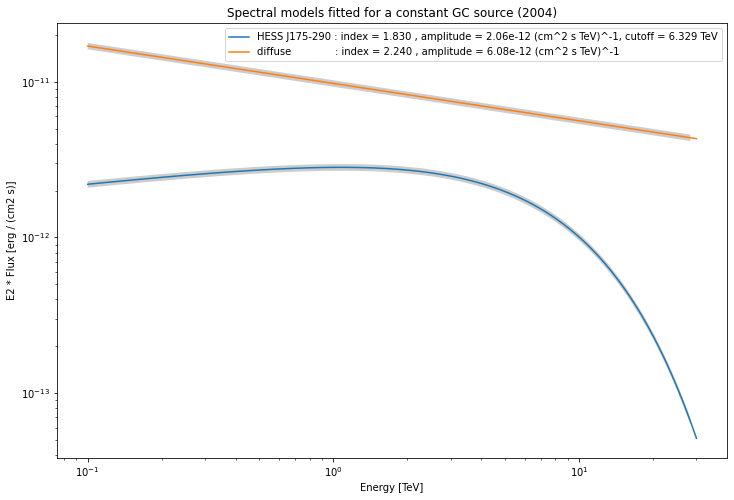

In [18]:
plot_spectrum(datasets_year["map_2004"].models, pathres,"example_model_2004_1cut_fr.pdf", "2004")

## Time evolution of the fluxes

In [19]:
def CalculateFluxFromModels(mapdataset, emin, emax):
    models  = mapdataset.models
    
    amplitudeGC = models[0].spectral_model.parameters['amplitude'].value
    amp_errGC = models[0].spectral_model.parameters['amplitude'].error
    
    amplitudediff = models[2].spectral_model.parameters['amplitude'].value
    amp_errdiff = models[2].spectral_model.parameters['amplitude'].error
    
    #norm = mapdataset.background_model.parameters['norm'].value
    #norm_err = mapdataset.background_model.parameters['norm'].error
    
    if isinstance(emin, u.Quantity):

        diffuse_flux = models[2].spectral_model.integral(emin, emax)
        GC_flux = models[0].spectral_model.integral(emin, emax)
        
    if np.isscalar(emin):
        emin = emin*u.TeV
        emax = emax*u.TeV
        diffuse_flux = models[2].spectral_model.integral(emin, emax)
        GC_flux = models[0].spectral_model.integral(emin, emax)

    return diffuse_flux, GC_flux, amplitudeGC, amp_errGC, amplitudediff, amp_errdiff#, norm, norm_err

In [20]:
# Extracting parameters from each years fitted model

emin = 1.0*u.TeV
emax = 10*u.TeV
resGC = []
resdiff = []
ampsGC = []
amp_errsGC = []
ampsdiff = []
amp_errsdiff = []
#norms = []
#norms_err = []


for year in years:
    dif , GC, amp, amp_err, ampdiff, amp_errdiff = CalculateFluxFromModels(datasets_year[f"map_{year}"] , emin, emax)
    
    resGC.append(GC.value)
    resdiff.append(dif.value)
    ampsGC.append(amp)
    amp_errsGC.append(amp_err)
    ampsdiff.append(ampdiff)
    amp_errsdiff.append(amp_errdiff)
   
    
    #norms.append(norm)
    #norms_err.append(norm_err)
    
resGC = np.asarray(resGC)
ampsGC = np.asarray(ampsGC)
amp_errsGC = np.asarray(amp_errsGC)
resdiff = np.asarray(resdiff)
ampsdiff = np.asarray(ampsdiff)
amp_errsdiff = np.asarray(amp_errsdiff)
#norms = np.asarray(norms)
#norms_err = np.asarray(norms_err)

In [21]:
# Errors computation

yerrGC = (resGC/ampsGC)*amp_errsGC
yerrdiff = (resdiff/ampsdiff)*amp_errsdiff

cross_term = []

#cov_per_year n'existe plus ???
#1,8,13,17

for k,year in zip(range(len(years)),years):
    term = 2*(datasets_year[f"map_{year}"].models.covariance.data[1,13]*yerrGC[k]*yerrdiff[k])/(resGC[k]*resdiff[k])
    cross_term.append(term)
      
yerr_rap = (resGC/resdiff)*np.sqrt((yerrGC/resGC)**2 + (yerrdiff/resdiff)**2 - cross_term )

In [22]:
datasets_year[f"map_{year}"].models.covariance.data[1,13]

0.0

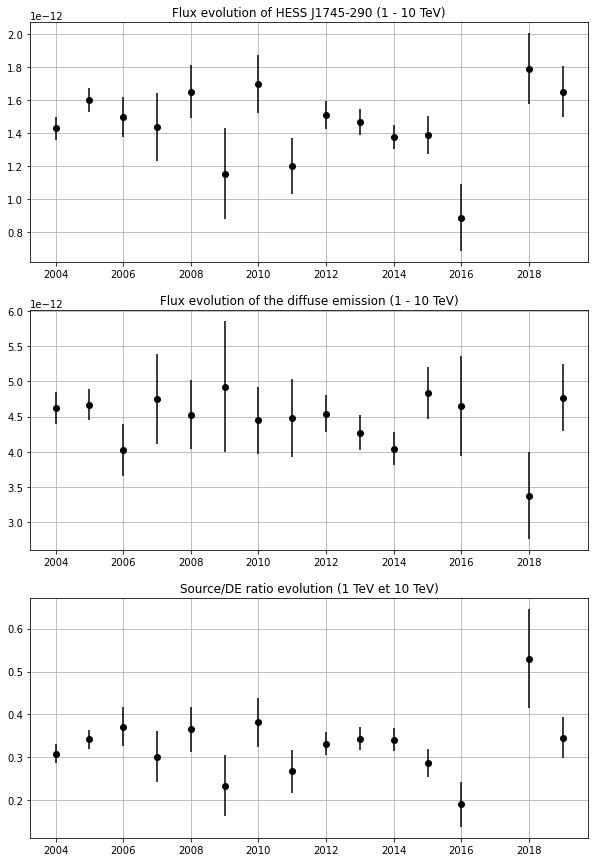

In [23]:
plt.figure(figsize=(10,15))

ax1 = plt.subplot(3,1,1)

plt.errorbar(years , resGC, yerr=yerrGC, fmt='ko')# ax=ax1)
plt.title("Flux evolution of HESS J1745-290 (1 - 10 TeV)")
plt.grid()

ax2 = plt.subplot(3,1,2)
plt.errorbar(years , resdiff, yerr=yerrdiff, fmt='ko')
plt.title("Flux evolution of the diffuse emission (1 - 10 TeV)")
plt.grid()

ax2 = plt.subplot(3,1,3)
plt.errorbar(years , resGC/resdiff, yerr=yerr_rap, fmt='ko')
plt.title("Source/DE ratio evolution (1 TeV et 10 TeV)")
plt.grid()


#ax4 = plt.subplot(4,1,4)
#plt.errorbar(years , norms, yerr=norms_err, fmt='ko')# ax=ax1)
#plt.title("Background normalisation evolution")
#plt.grid()

plt.savefig(pathres/"GCDEflux_evolution_04_19_fr.pdf")

## Fitting a time evolution model

In [24]:
import scipy.stats as stats

from astropy.modeling import models, fitting

from scipy.stats import chisquare, chi2

# chi2 non réduit
def chisq(obs, exp, error):
    chisq = 0
    for i in range(len(obs)):
        chisq = chisq + ((obs[i]-exp)**2)/(error[i]**2)
    return chisq

# chi2 réduit
def chisqr(obs, exp, error):
    chisqr = 0
    for i in range(len(obs)):
        chisqr = chisqr + ((obs[i]-exp)**2)/(error[i]**2)
    return chisqr/(len(obs) -1)

def pval(obs, exp, error, nddl): # number of DoF is the number of points minus number of fitted parameters (1 for a constant)
    chisq = 0
    for i in range(len(obs)):
        chisq = chisq + ((obs[i]-exp)**2)/(error[i]**2)
    pval = 1 - chi2.cdf(chisq, nddl)
    return pval

### Evolution for the central source

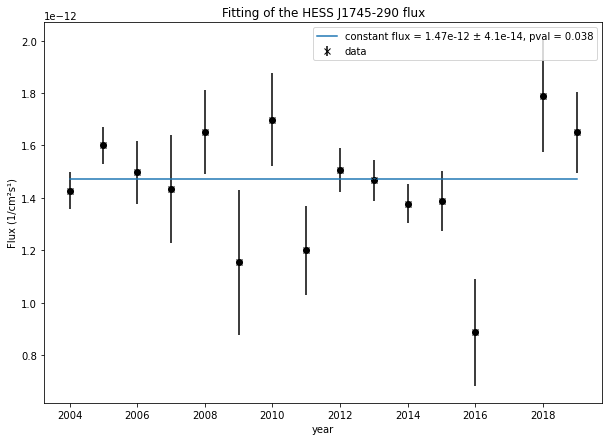

In [25]:
x = years
y = resGC
y_uncs = yerrGC


# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1e-12)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y , weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = y
A2 = t(2004)
err_bars = y_uncs

pv = pval(A1, A2, err_bars, len(A1)-1)


error_const = np.sqrt(sum([a**2 for a in err_bars]))/len(A1)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="data")
plt.plot(x, t(x), label=f"constant flux = {A2:0.2e} ± {error_const:0.1e}, pval = {pv:0.3f}")
plt.xlabel('year')
plt.ylabel('Flux (1/cm²s¹)')
plt.legend(loc=1)
plt.title("Fitting of the HESS J1745-290 flux")
plt.savefig(pathres/"LC_GC_1cut_fr.pdf")

### Evolution of the diffuse emission

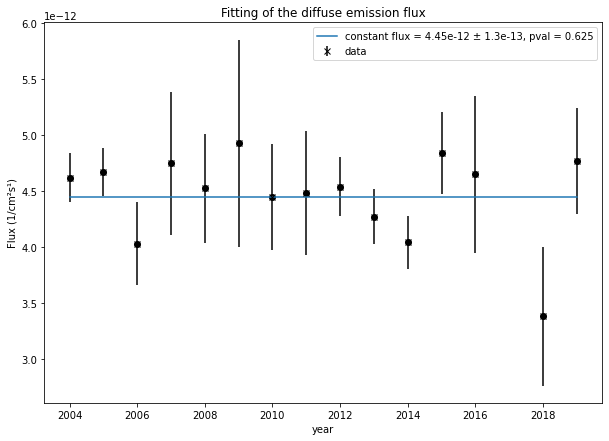

In [26]:
x = years
y = resdiff
y_uncs = yerrdiff


# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1e-10)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y, weights=1.0/y_uncs)

A1 = y
A2 = t(2004)
err_bars = y_uncs
#chi2, pval = stats.chisquare(A1, A2)
chi2r = chisqr(A1, A2, err_bars)

pv = pval(A1, A2, err_bars, len(A1)-1)

error_const = np.sqrt(sum([a**2 for a in err_bars]))/len(A1)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="data")
plt.plot(x, t(x), label=f"constant flux = {A2:0.2e} ± {error_const:0.1e}, pval = {pv:0.3f}")
plt.xlabel('year')
plt.ylabel('Flux (1/cm²s¹)')
plt.legend(loc=1)
plt.title("Fitting of the diffuse emission flux")
plt.savefig(pathres/"LC_DE_1cut_fr.pdf")

### Evolution of the ratio

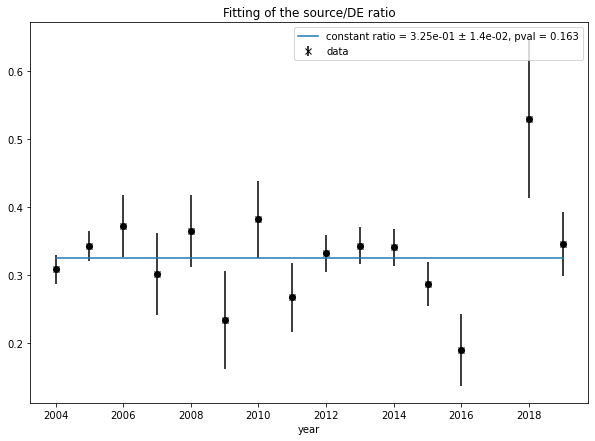

In [27]:
x = years
y = resGC/resdiff
y_uncs = yerr_rap


# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(0.6)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y, weights=1.0/y_uncs)


A1 = y
A2 = t(2004)
err_bars = yerr_rap

pv = pval(A1, A2, err_bars, len(A1)-1)

error_const = np.sqrt(sum([a**2 for a in err_bars]))/len(A1)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="data")
plt.plot(x, t(x), label=f"constant ratio = {A2:0.2e} ± {error_const:0.1e}, pval = {pv:0.3f}")
plt.xlabel('year')
plt.ylabel('')
plt.legend(loc=1)

plt.title("Fitting of the source/DE ratio")
plt.savefig(pathres/"LC_ratio_1cut_fr.pdf")

## Model predictions

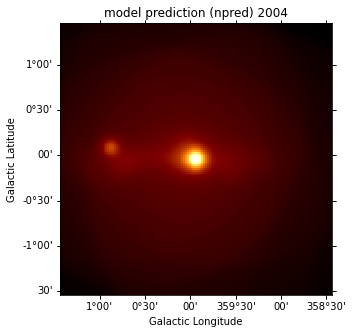

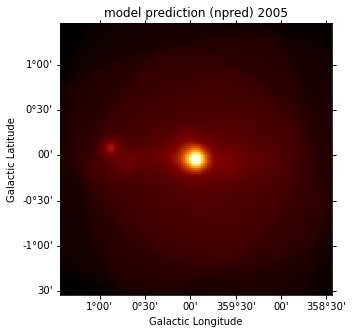

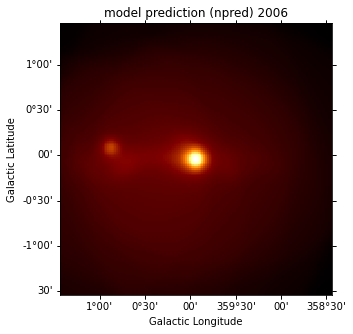

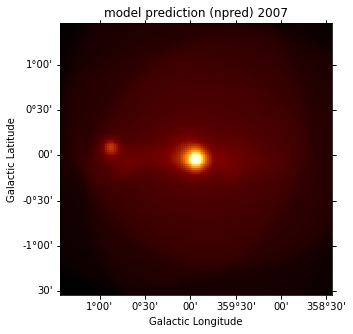

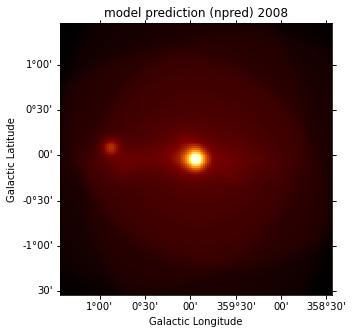

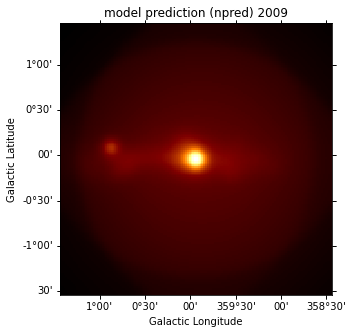

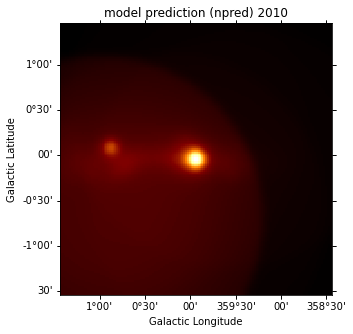

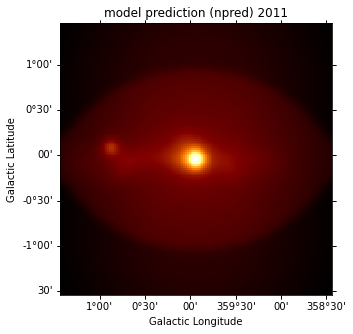

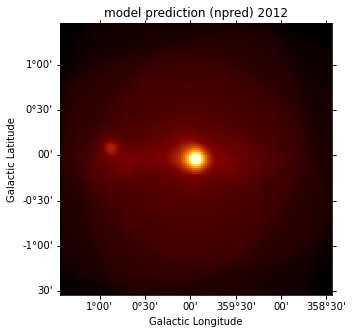

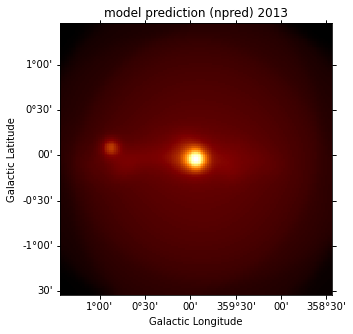

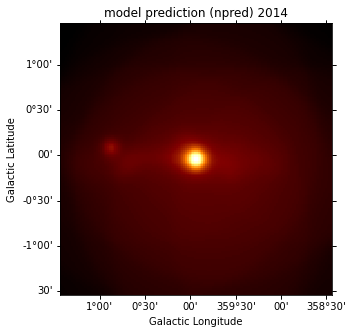

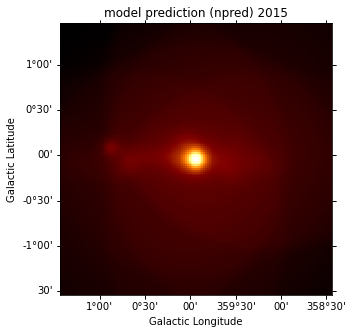

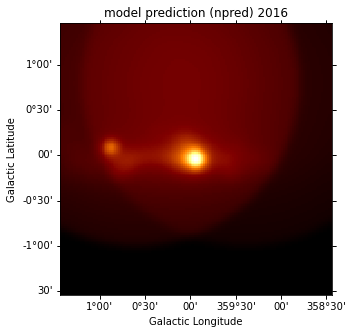

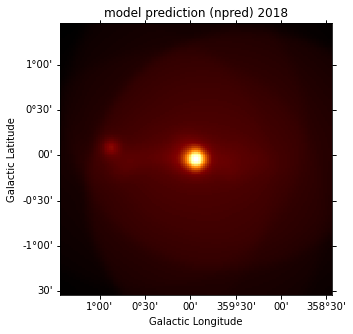

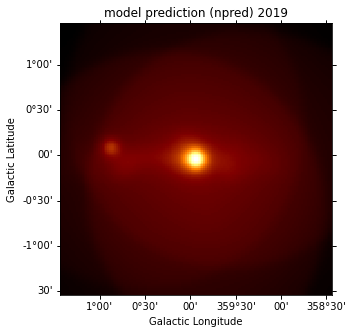

In [28]:
pathm = Path(pathres/"model_maps")
pathm.mkdir(exist_ok=True)

for year in years:
    plt.figure(figsize=(5,5))
    datasets_year[f"map_{year}"].npred().sum_over_axes().cutout(src_pos,3*u.deg).smooth('0.05 deg').plot()
    plt.title("model prediction (npred) " + str(year))
    
    name ="model_"+ str(year)+"_map_fr.pdf"
    plt.savefig(pathm/name)

## Residuals

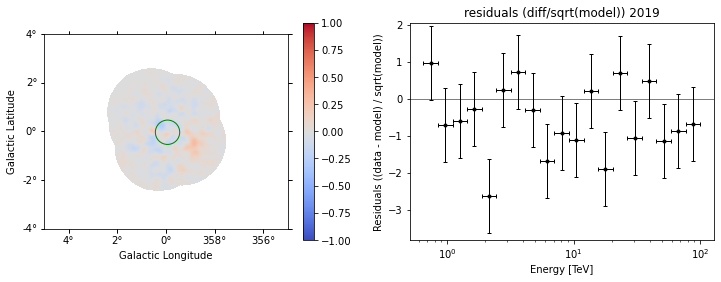

In [29]:
pathr = Path(pathres/"residuals")
pathr.mkdir(exist_ok=True)

kwargs_spatial = {'vmin':-1, 'vmax':1 } # nécessaire ?

kwargs_spectral = {'method':'diff/sqrt(model)', 'region' : CircleSkyRegion(
    center=src_pos, radius=0.5 * u.deg
)}


for year in years:
    datasets_year[f"map_{year}"].plot_residuals(kwargs_spatial=kwargs_spatial, kwargs_spectral=kwargs_spectral)
    name = "residuals_"+str(year)+"_fr_full.pdf"
    plt.title("residuals (diff/sqrt(model)) " + str(year))
    plt.savefig(pathr/name, overwrite=True)

## Significance

/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/a

CPU times: user 1min 27s, sys: 20.8 s, total: 1min 48s
Wall time: 1min 41s


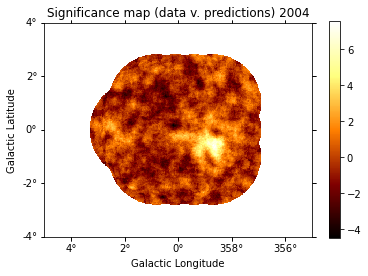

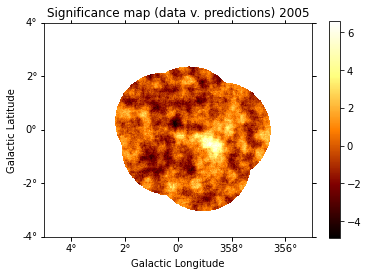

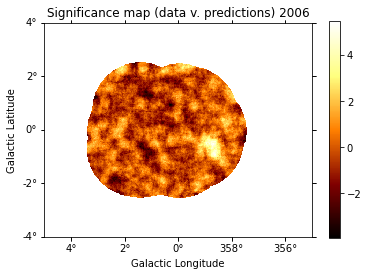

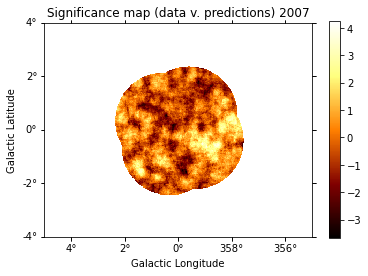

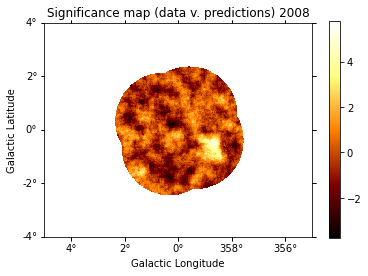

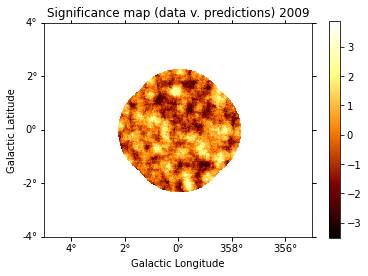

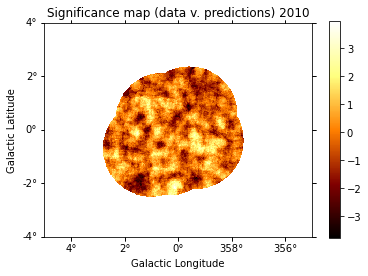

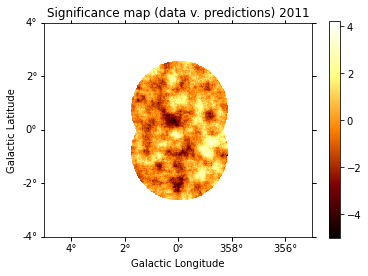

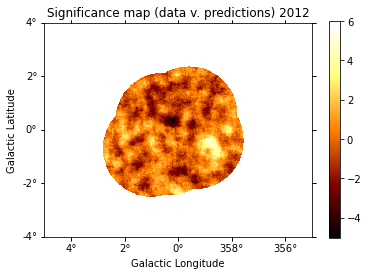

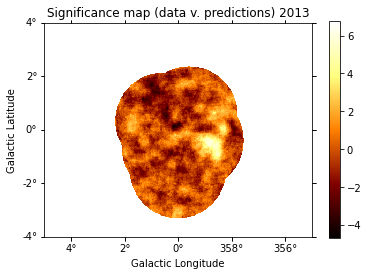

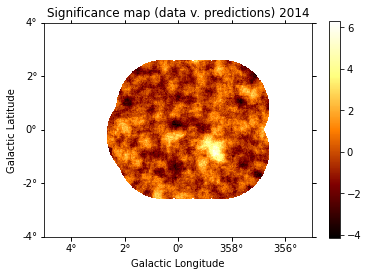

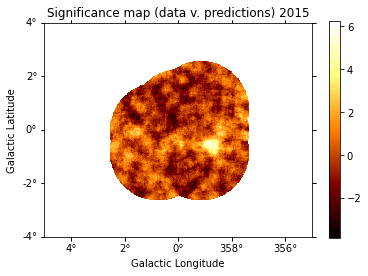

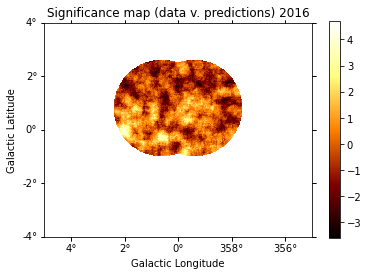

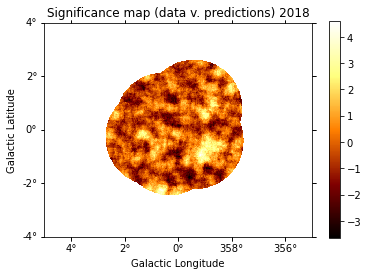

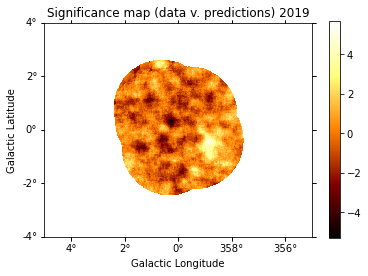

In [15]:
%%time
#très long ?

paths = Path(pathres/"significance")
paths.mkdir(exist_ok=True)

lima_significances = dict()

for year in years:
    plt.figure()

    lima_estimator = ExcessMapEstimator("0.2 deg", selection_optional=[] )
    
    lima_significances[year] = lima_estimator.run(datasets_year[f"map_{year}"])
    
    lima_significances[year]['sqrt_ts'].plot(add_cbar=True)
    name = "significance_"+str(year)+"_fr_full.pdf"
    
    plt.title("Significance map (data v. predictions) "+str(year))
    plt.savefig(paths/name, overwrite=True)

### Significance distributions

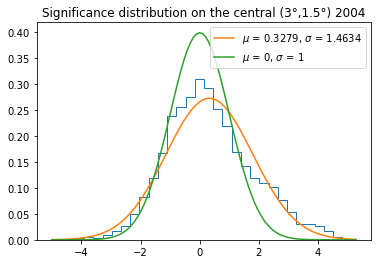

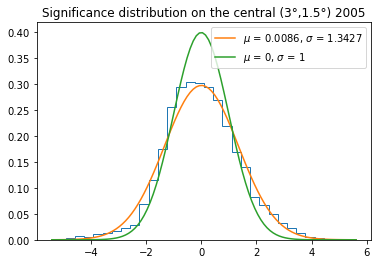

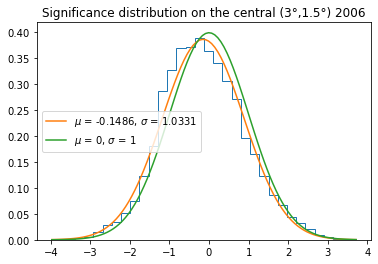

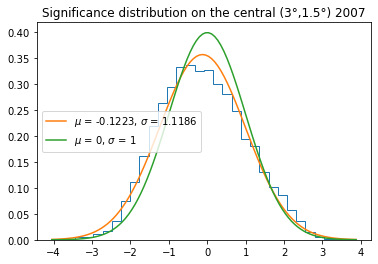

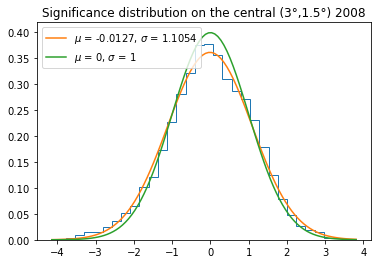

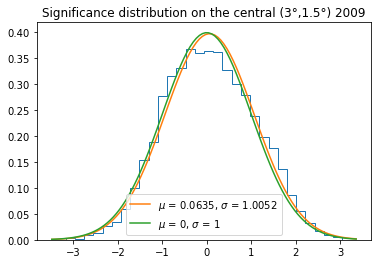

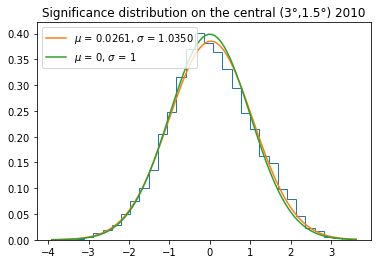

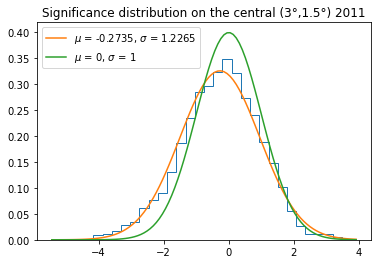

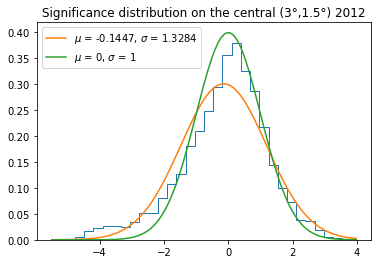

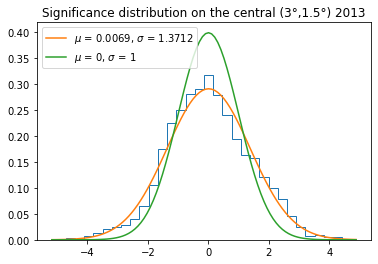

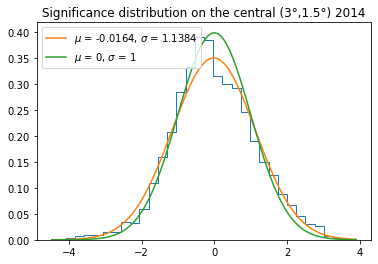

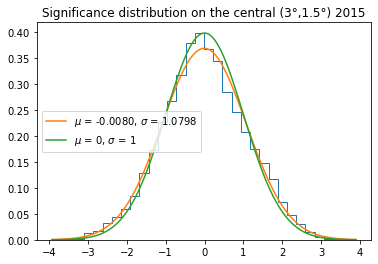

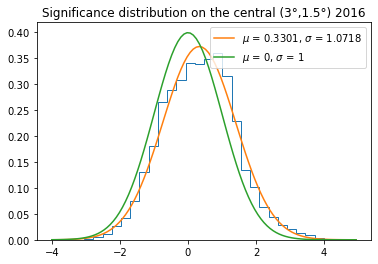

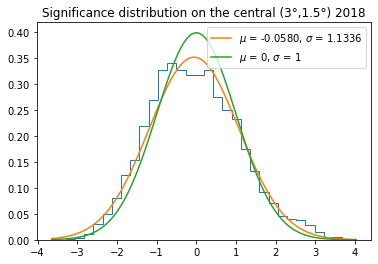

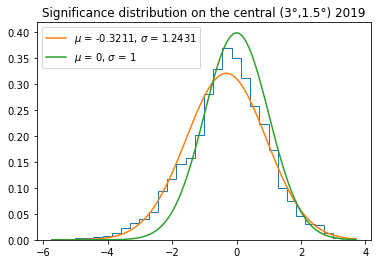

In [16]:
from scipy.stats import norm

pathh = Path(paths/"significance_distrib")
pathh.mkdir(exist_ok=True)

for year in years:
    plt.figure()
    signidata = lima_significances[year]['sqrt_ts'].cutout(position=src_pos, width=(3 * u.deg, 1.5* u.deg)).data
    
    # on masque la région en bas à droite
    mask = fit_mask.reduce_over_axes(func=np.logical_or).cutout(position=src_pos, width=(3 * u.deg, 1.5* u.deg)).data
    
    plt.hist(signidata[0,mask].flatten(),30, histtype='step', density=True)
    
    mean,std=norm.fit(signidata[0,mask])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    y = norm.pdf(x, mean, std)
    plt.plot(x, y, label=r'$\mu$ = {0:03.4f}, $\sigma$ = {1:03.4f}'.format(mean,std))
    y2= norm.pdf(x, 0, 1)   
    plt.plot(x, y2 ,label=r'$\mu$ = 0, $\sigma$ = 1')
    
    plt.legend()
    
    name = "significance_hist"+str(year)+"_fr_full.pdf"
    plt.title("Significance distribution on the central (3°,1.5°) "+str(year))
    plt.savefig(pathh/name, overwrite=True)

## Flux points

One alternative way to assess spectral variability over the years is to compute flux points for each year (but on quite large energy bins since we will lack the data to compute more than a few points).

In [17]:
def FluxPointsFitting(dataset, e_edges):
    # this function has to be given the number of the source model in case of multiple models
    # more parameters exist to initialise the estimator
    
    fpe = FluxPointsEstimator( energy_edges=e_edges, source =0) 
    flux_points = fpe.run(datasets=[dataset]) 
    return flux_points

In [18]:
e_edges = np.array([0.5,1,2,5,10]) * u.TeV

In [19]:
years = [k for k in range(2004,2020)]

In [20]:
years.remove(2017)

In [ ]:
flux_years = {0 : [], 1 : [], 2 : [], 3 : []}

for year in years:
    flux_points = FluxPointsFitting(datasets_year[f"map_{year}"], e_edges)
    for k in range(len(e_edges) - 1):
        flux_years[k].append(flux_points.table[k])

In [ ]:
x = years

for k in range(len(e_edges) - 1) :
    y = []
    y_uncs = []
   
    for l,year in zip(range(len(years)),years):
        y.append(flux_years[k][l]['dnde'])
        y_uncs.append(flux_years[k][l]['dnde_err'])

    
    t_init = models.Const1D(1e-12)
    fit_t = fitting.LevMarLSQFitter()
    t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

    A1 = y
    A2 = t(2004)
    err_bars = y_uncs
    
    pv = pval(A1, A2, err_bars, len(A1)-1)
    
    
    error_const = np.sqrt(sum([a**2 for a in err_bars]))/len(A1)


    # Plot the data with the best-fit model
    plt.figure(figsize=(10,7))
    plt.plot(x, y, 'ko')
    plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="data")
    plt.plot(x, t(x), label=f"constant flux = {A2:0.2e} ± {error_const:0.1e}, pval = {pv:0.2e}")
    
    plt.xlabel('year')
    plt.ylabel('Flux (1/cm²s¹)')
    
    plt.legend(loc=1)
    
    plt.title("Flux points of HESS J1745-290 ("+str(e_edges[k]) +" - "+ str(e_edges[k+1])+")")
    name = "GC_FP_bin"+str(k)+"_fr.pdf"
    plt.savefig(pathres/name)